In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import argparse
import pathlib
from tensorflow.keras import layers
import sys
import numpy as np
from sklearn.decomposition import IncrementalPCA
from scipy.stats import wasserstein_distance,energy_distance
from sklearn.decomposition import PCA
import os
import matplotlib.pyplot as plt

# Lista de Variables para Configuración

In [ ]:
## Lista de Parametros
Arq = 'vgg16'
Cap = 'sequential'
Att = 'CW'
Epx = '001'
Epx_val = 0.01
DS = 'mnist'

In [ ]:
def FGSM_GEN(model, image_in, target_label, epsilon,tiles=10):

  with tf.GradientTape() as tape:
    tape.watch(image_in)
    image= tf.expand_dims(image_in, axis=0)
    image = tf.tile(image, (tiles, 1, 1, 1))
    prediction = model(image)
    loss = tf.math.reduce_mean(nll(target_label, prediction))

  gradient = tape.gradient(loss, image_in)
  perturbation = epsilon * tf.sign(gradient)
  adversary = image_in + perturbation
  adversary = tf.clip_by_value(adversary, 0, 1)

  return adversary

## Ataque PGD
'''def pgd_attack(model, image, target_label, epsilon=0.15, num_steps=100, step_size=0.01):
    original_image = tf.identity(image)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            logits = model(tf.expand_dims(image, axis=0))
            loss =- tf.keras.losses.CategoricalCrossentropy(from_logits=True)(tf.expand_dims(target_label, axis=0), logits)
            #loss = -tf.reduce_sum(target_label * tf.math.log(logits))

        gradient = tape.gradient(loss, image)
        perturbation = step_size * tf.sign(gradient)
        image = tf.clip_by_value(image + perturbation, original_image - epsilon, original_image + epsilon)
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image'''

## Ataque C&W
def pgd_attack(model, image, target_label, num_steps=500, step_size=0.0, epsilon=0.01):
    def loss_(image,target_label):
        image = tf.expand_dims(image, axis=0)
        image_tile = tf.tile(image, (5, 1, 1, 1))
        logits = model(image_tile)
        targets = tf.reduce_sum(logits * target_label, axis=1)
        others = tf.reduce_max(logits * (1 - target_label), axis=1)
        return tf.maximum(0.0, others - targets + step_size)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            loss = tf.math.reduce_mean(loss_(image,target_label))

        gradient = tape.gradient(loss, image)
        image = image - epsilon * tf.sign(gradient)
        image = tf.clip_by_value(image, 0., 255.)

    return image
def pgd_attack_soft(model, image, target_label, epsilon=0.15, num_steps=1000, step_size=0.001):
    original_image = tf.identity(image)

    for _ in range(num_steps):
        with tf.GradientTape() as tape:
            tape.watch(image)
            logits = model(tf.expand_dims(image, axis=0))
            loss =- tf.keras.losses.CategoricalCrossentropy()(tf.expand_dims(target_label, axis=0), logits)
            #loss = -tf.reduce_sum(target_label * tf.math.log(logits))

        gradient = tape.gradient(loss, image)
        perturbation = step_size * tf.sign(gradient)
        image = tf.clip_by_value(image + perturbation, original_image - epsilon, original_image + epsilon)
        image = tf.clip_by_value(image, 0.0, 1.0)

    return image
def get_layer_dictionary(model_pret,input_shape=(32,32,1)):
  dict_models={}
  input=xvar=tf.keras.Input(input_shape)
  for idx,layer in enumerate(model_pret.layers):
    xvar=layer(xvar)
    dict_models[layer.name]=tf.keras.Model(input,xvar,name=layer.name)
    print(idx,layer.name)
  return dict_models

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

## Ejemplo solo con la clase 0 para los de test-train

In [ ]:
from models.vgg_b1_MNF_CA import VGG as VGGb1
from models.vgg_bt_MNF_CA import VGG as VGGbt
vgg_full_mnist=VGGb1(Arq,10)
vgg_1c_mnist=VGGbt(Arq,10)

vgg_full_mnist.build((None,32,32,1))
vgg_full_mnist.load_weights('/content/drive/MyDrive/Maestria/Trabajo de Grado/Git/Ejem_Adversarios_UElBosque/Modelos_Final/folder_models_vgg/vgg16MNFLUbt_CA/mnist/checkpoint')
vgg_1c_mnist.build((None,32,32,1))
vgg_1c_mnist.load_weights('/content/drive/MyDrive/Maestria/Trabajo de Grado/Git/Ejem_Adversarios_UElBosque/Modelos_Final/folder_models_vgg/vgg16MNFLUb1_CA/mnist/checkpoint')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
def nll(y_true, y_pred):
    cross_entropy=-y_pred.log_prob(y_true)
    nll = tf.reduce_mean(cross_entropy)+vgg_full_mnist.kl_div() / len_train
    return nll
vgg_full_mnist.compile(optimizer="adam",
                loss=nll,
                metrics=["accuracy"])
vgg_1c_mnist.compile(optimizer="adam",
                loss=nll,
                metrics=["accuracy"])

# Verificar que los tres modelos estan correctamente cargados

# Victima 6

## Ataque 0

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 6
Vic_loc = 11
Cat = 0

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 35s 621ms/step - loss: inf - accuracy: 0.9976


[inf, 0.9975961446762085]

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 19s 222ms/step - loss: inf - accuracy: 0.9856


[inf, 0.9855769276618958]

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


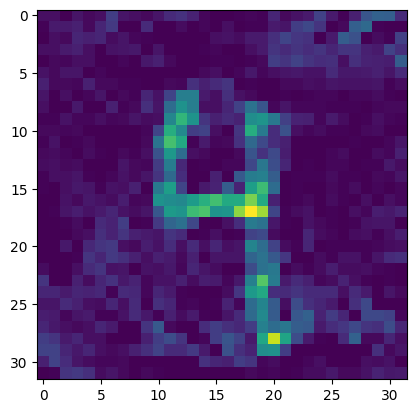

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.1892390073607264
distancia energia distribucion base y el ejemplo natural  0.1434773327578388


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.9278514624589566
distancia energia distribucion base y el ejemplo adversario  0.3794851914380546


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-29-2bd6de1d3841>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-29-2bd6de1d3841>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

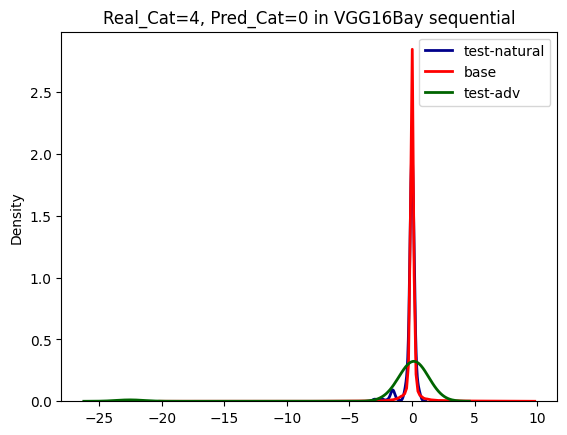

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

el label verdadero es:  4


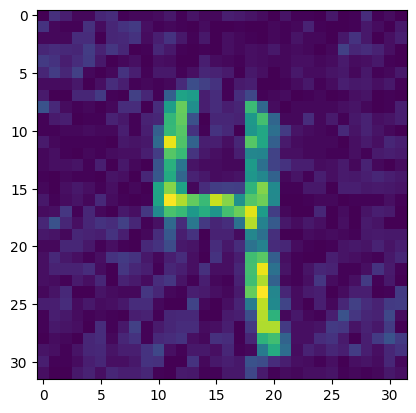

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

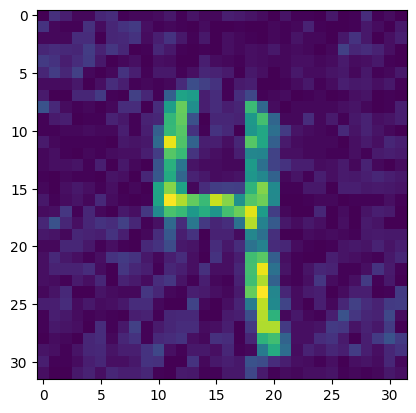

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.14470780017738383
distancia energia distribucion base y el ejemplo natural  0.130470630840002


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.8297685286295424
distancia energia distribucion base y el ejemplo adversario  0.396890680698231


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-45-ee29668e5210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-45-ee29668e5210>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

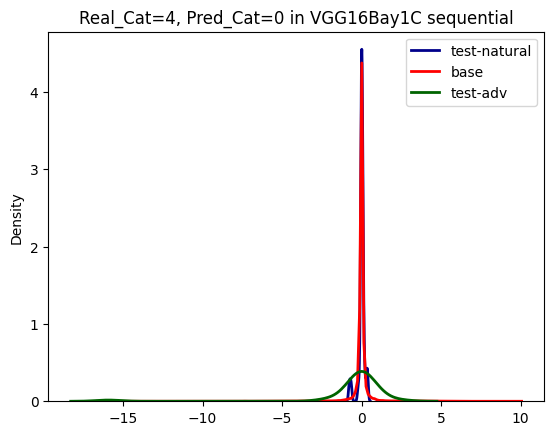

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 6s 372ms/step - loss: inf - accuracy: 0.9958


[inf, 0.9958333373069763]

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 2s 108ms/step - loss: inf - accuracy: 0.9979


[inf, 0.9979166388511658]

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


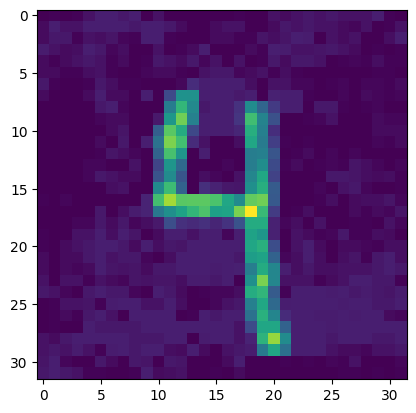

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.09677343970131244
distancia energia distribucion base y el ejemplo natural  0.10696078333063097


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.7233078774446157
distancia energia distribucion base y el ejemplo adversario  0.3711761047522642


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-66-2bd6de1d3841>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-66-2bd6de1d3841>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

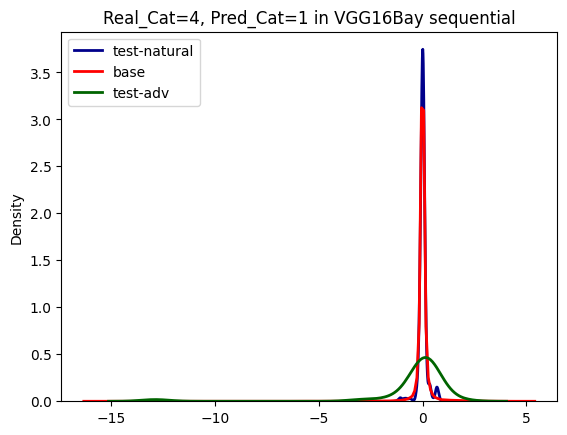

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

el label verdadero es:  4


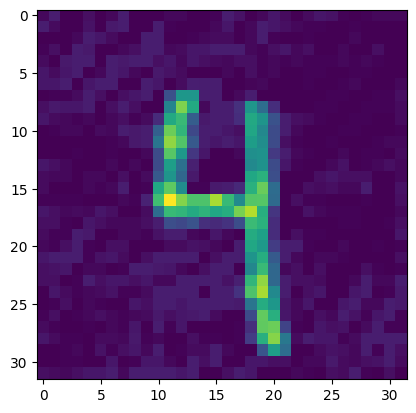

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

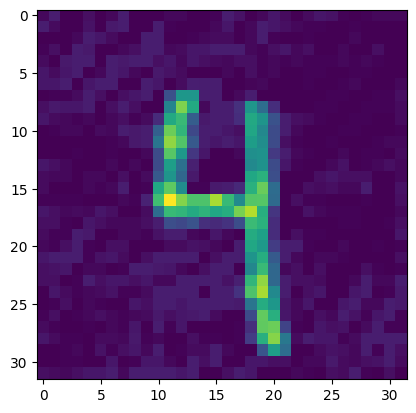

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.1163346504666701
distancia energia distribucion base y el ejemplo natural  0.1021240849259984


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.7330535484623154
distancia energia distribucion base y el ejemplo adversario  0.43929496300974386


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-82-ee29668e5210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-82-ee29668e5210>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

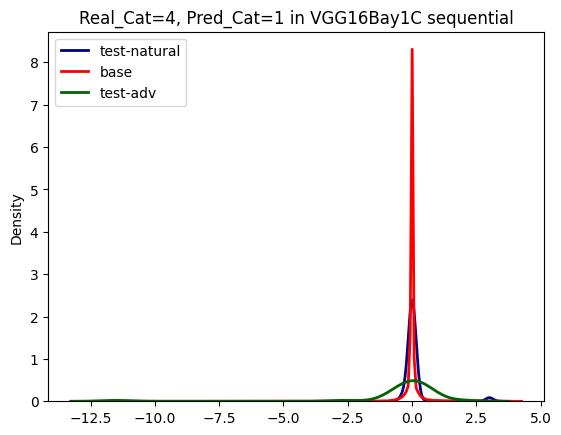

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 4s 271ms/step - loss: inf - accuracy: 0.9888


[inf, 0.9888392686843872]

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 2s 136ms/step - loss: inf - accuracy: 0.9900


[inf, 0.9899553656578064]

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


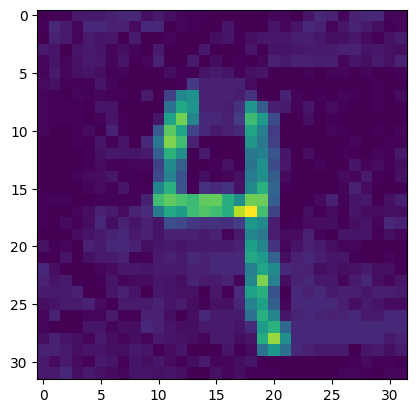

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.18208667039957688
distancia energia distribucion base y el ejemplo natural  0.13548096664075243


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.785546541964927
distancia energia distribucion base y el ejemplo adversario  0.33782467272422895


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-103-2bd6de1d3841>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-103-2bd6de1d3841>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

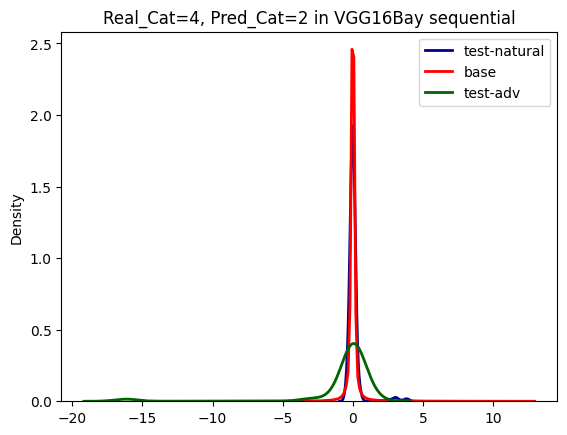

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

el label verdadero es:  4


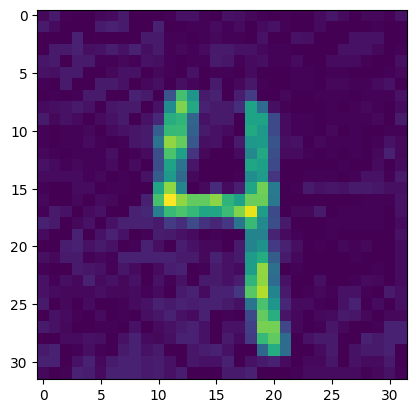

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

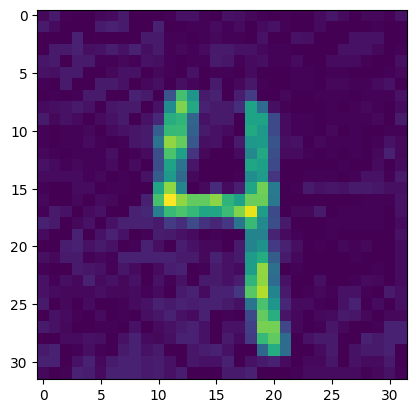

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.15200335186551764
distancia energia distribucion base y el ejemplo natural  0.12807717945709726


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.7795666743616264
distancia energia distribucion base y el ejemplo adversario  0.40896909844665735


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-119-ee29668e5210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-119-ee29668e5210>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

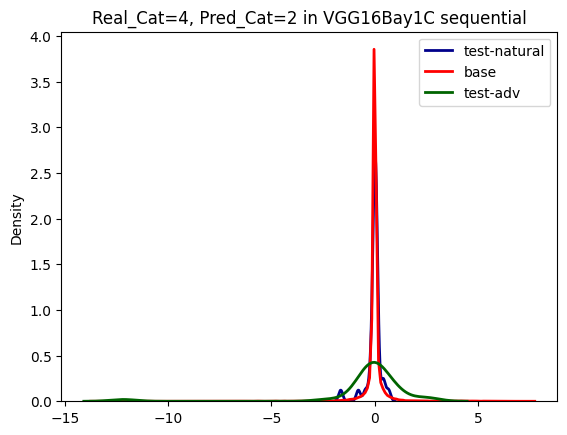

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 5s 354ms/step - loss: inf - accuracy: 0.9911


[inf, 0.9910714030265808]

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 2s 127ms/step - loss: inf - accuracy: 0.9978


[inf, 0.9977678656578064]

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

el label verdadero es:  4


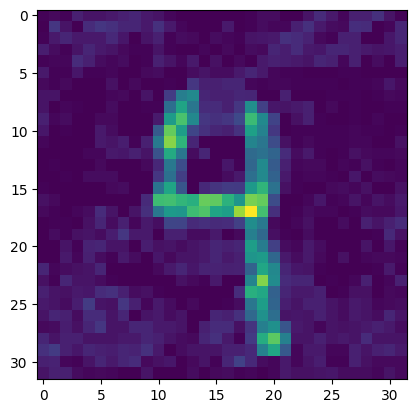

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.1819663293641731
distancia energia distribucion base y el ejemplo natural  0.13428981538772777


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.6610341525861619
distancia energia distribucion base y el ejemplo adversario  0.2631637759496069


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-140-2bd6de1d3841>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-140-2bd6de1d3841>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

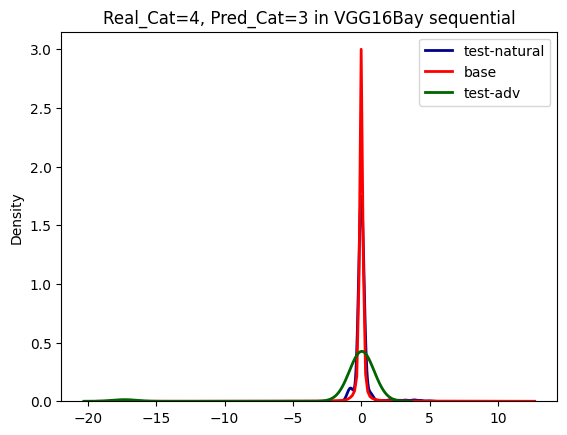

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

el label verdadero es:  4


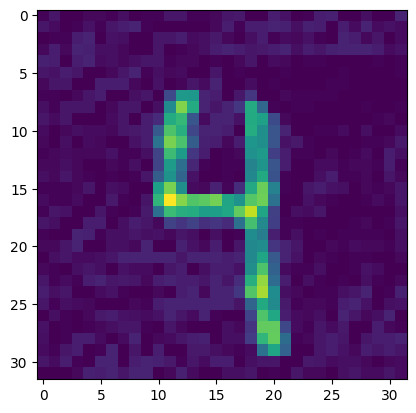

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

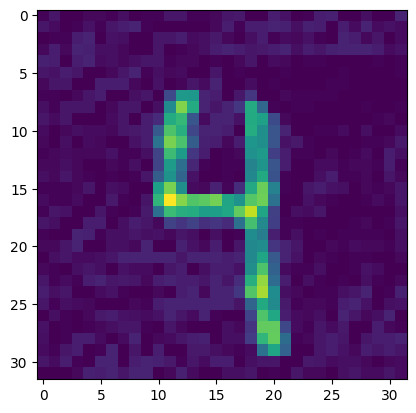

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.14865772012979667
distancia energia distribucion base y el ejemplo natural  0.12073443186046022


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.8155879652811843
distancia energia distribucion base y el ejemplo adversario  0.3748263246194981


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-156-ee29668e5210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-156-ee29668e5210>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

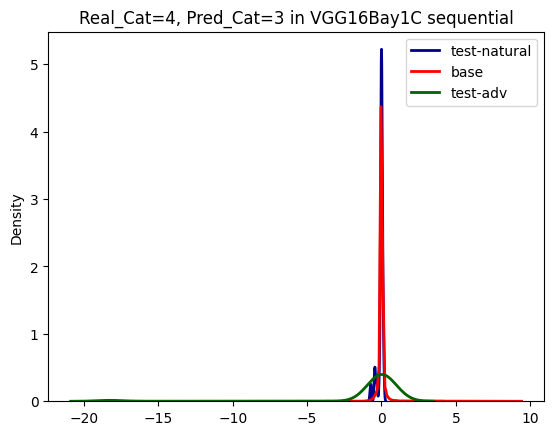

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 4s 277ms/step - loss: inf - accuracy: 0.9988


[inf, 0.9987980723381042]

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 2s 114ms/step - loss: inf - accuracy: 0.9904


[inf, 0.9903846383094788]

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

el label verdadero es:  4


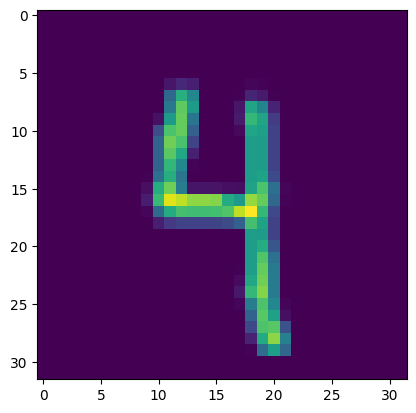

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.16700277285221585
distancia energia distribucion base y el ejemplo natural  0.13368823503037783


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.1624417088010222
distancia energia distribucion base y el ejemplo adversario  0.13389389867940032


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-177-2bd6de1d3841>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-177-2bd6de1d3841>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

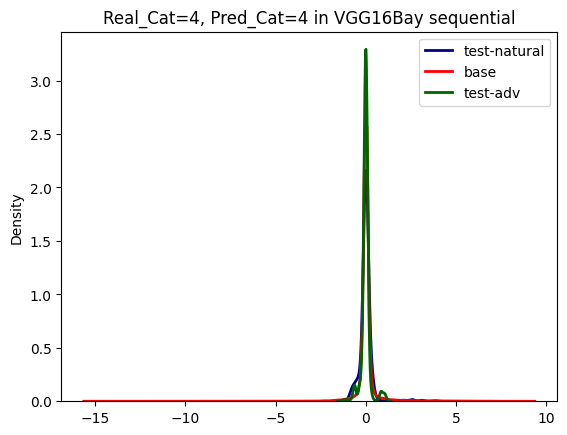

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

el label verdadero es:  4


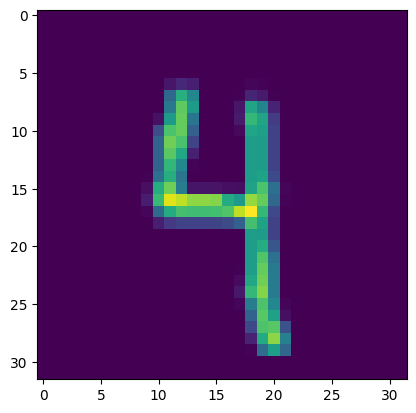

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

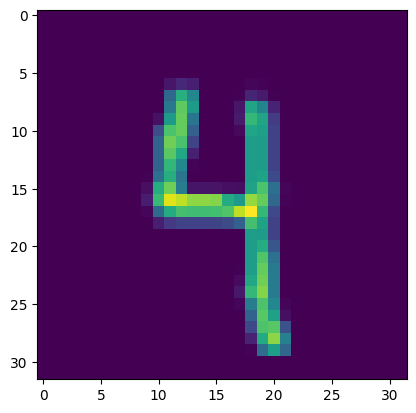

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.16794801223648698
distancia energia distribucion base y el ejemplo natural  0.12376597346024576


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.13988703770945582
distancia energia distribucion base y el ejemplo adversario  0.11960842746821536


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-193-ee29668e5210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-193-ee29668e5210>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

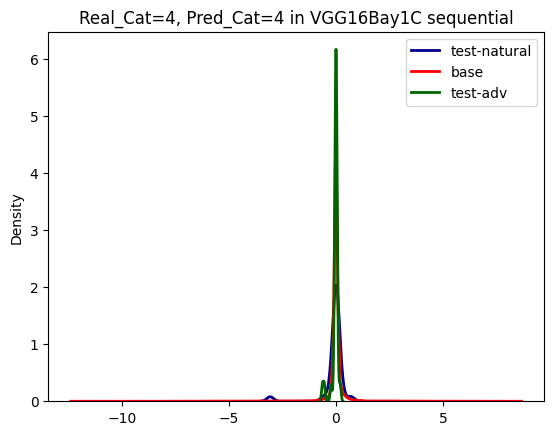

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

12/12 [==============================] - 4s 280ms/step - loss: inf - accuracy: 0.9896


[inf, 0.9895833134651184]

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

12/12 [==============================] - 1s 113ms/step - loss: inf - accuracy: 0.9870


[inf, 0.9869791865348816]

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

el label verdadero es:  4


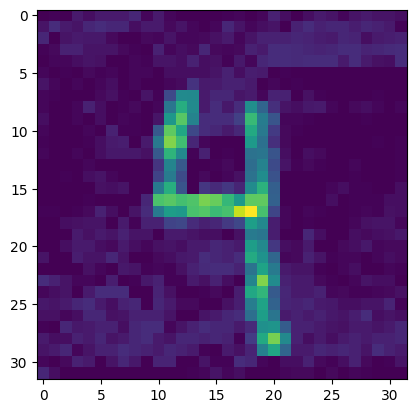

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.18885953272100092
distancia energia distribucion base y el ejemplo natural  0.14748536331910952


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.600352955980388
distancia energia distribucion base y el ejemplo adversario  0.27902597132480217


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-214-2bd6de1d3841>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-214-2bd6de1d3841>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

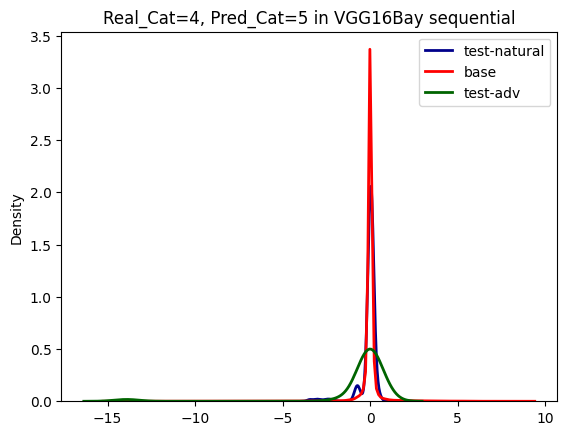

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

el label verdadero es:  4


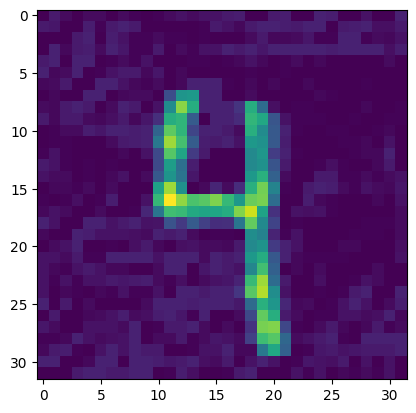

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]
[5]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

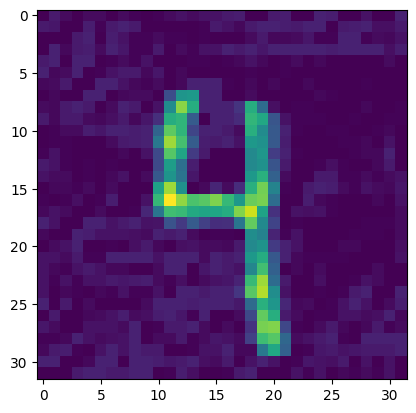

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.21251974240465504
distancia energia distribucion base y el ejemplo natural  0.1333748641961539


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.6570068218445816
distancia energia distribucion base y el ejemplo adversario  0.29956497529340487


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-230-ee29668e5210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-230-ee29668e5210>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

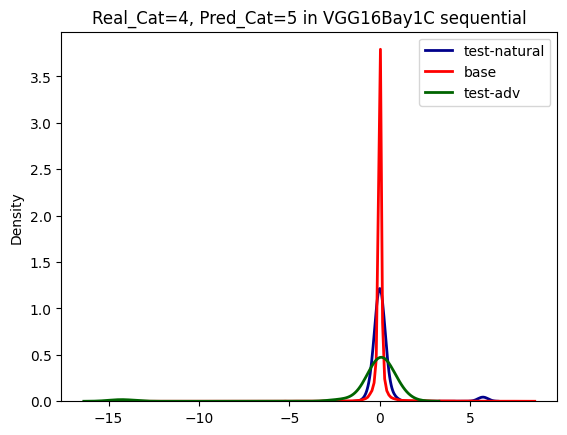

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 7

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 7

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 21s 371ms/step - loss: inf - accuracy: 0.9743


[inf, 0.9743303656578064]

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 12s 158ms/step - loss: inf - accuracy: 0.9922


[inf, 0.9921875]

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

el label verdadero es:  4


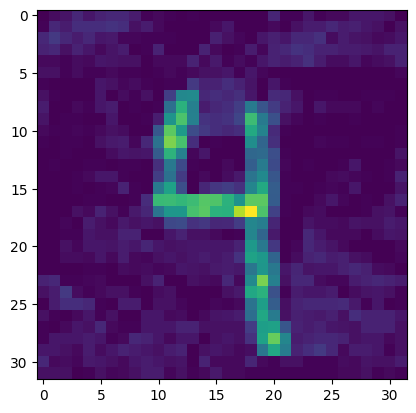

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.24312928248822202
distancia energia distribucion base y el ejemplo natural  0.1520330753812163


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.6180894259379287
distancia energia distribucion base y el ejemplo adversario  0.28920094194470125


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-31-2bd6de1d3841>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-31-2bd6de1d3841>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

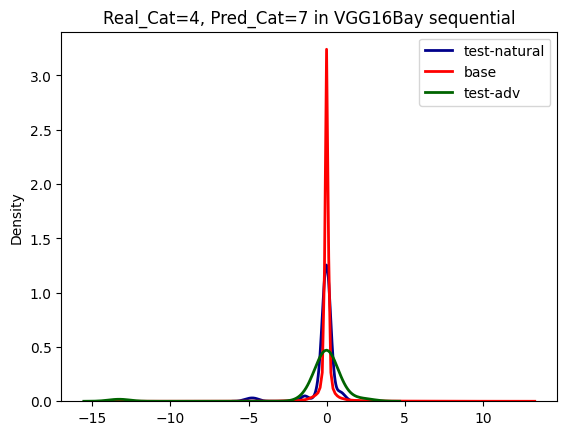

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

el label verdadero es:  4


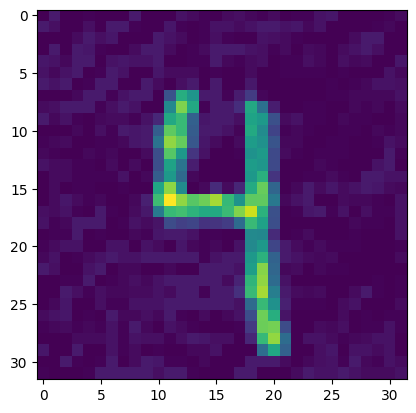

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]
[7]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

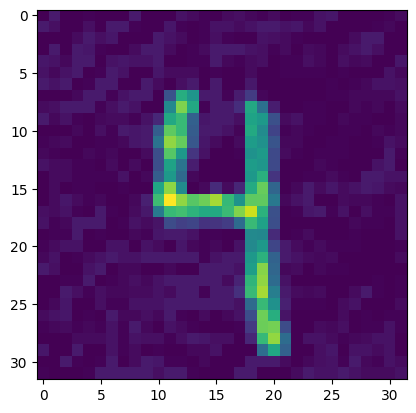

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.1870561462956997
distancia energia distribucion base y el ejemplo natural  0.14964371137692564


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.5664116211779193
distancia energia distribucion base y el ejemplo adversario  0.3004765757837282


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-47-ee29668e5210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-47-ee29668e5210>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

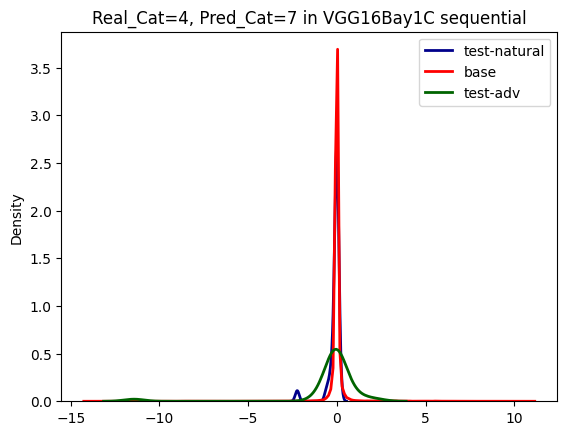

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 4s 277ms/step - loss: inf - accuracy: 0.9976


[inf, 0.9975961446762085]

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

13/13 [==============================] - 2s 114ms/step - loss: inf - accuracy: 0.9940


[inf, 0.9939903616905212]

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

el label verdadero es:  4


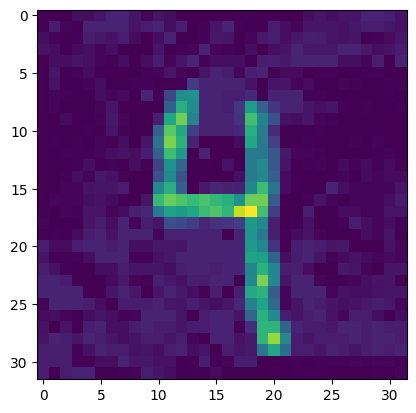

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.19072694443778268
distancia energia distribucion base y el ejemplo natural  0.14838290339392307


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.6313286684121017
distancia energia distribucion base y el ejemplo adversario  0.2807023365362897


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-68-2bd6de1d3841>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-68-2bd6de1d3841>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distrib

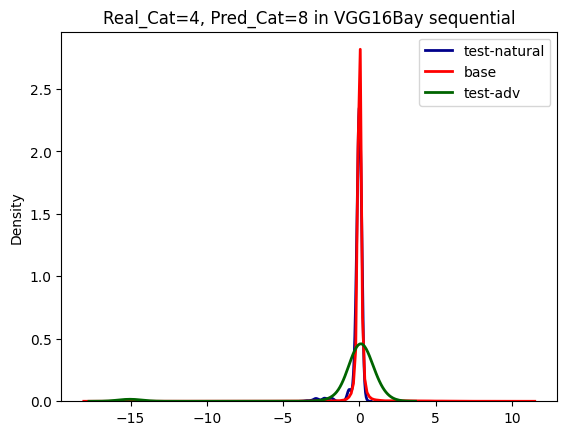

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

el label verdadero es:  4


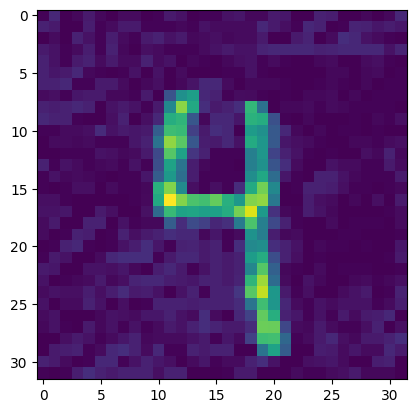

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]
[8]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

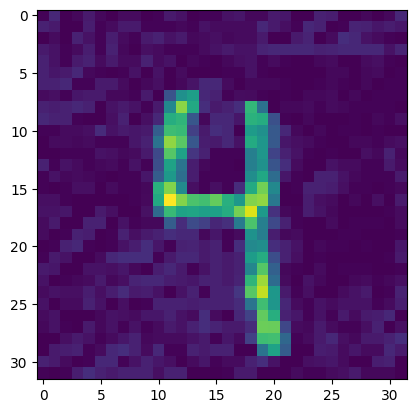

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.20079709520275904
distancia energia distribucion base y el ejemplo natural  0.1364205758066842


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.99017512399829
distancia energia distribucion base y el ejemplo adversario  0.4159621672342698


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-84-ee29668e5210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-84-ee29668e5210>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

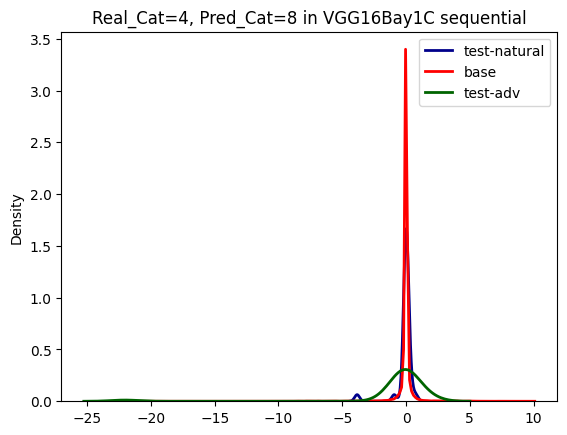

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 4s 270ms/step - loss: inf - accuracy: 0.9654


[inf, 0.9654017686843872]

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

14/14 [==============================] - 2s 114ms/step - loss: inf - accuracy: 0.9900


[inf, 0.9899553656578064]

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

el label verdadero es:  4


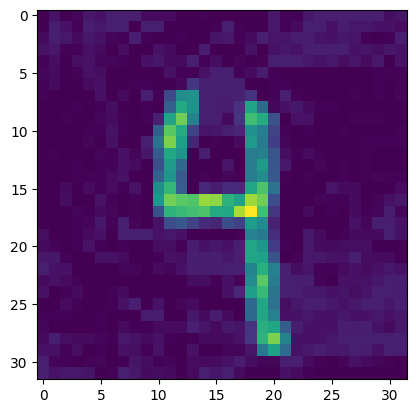

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.23382102044992573
distancia energia distribucion base y el ejemplo natural  0.1590702868280197


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.3728826414139255
distancia energia distribucion base y el ejemplo adversario  0.18000967819437788


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-105-2bd6de1d3841>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-105-2bd6de1d3841>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

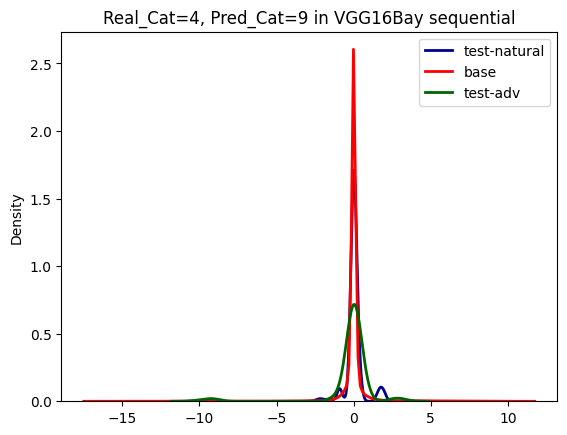

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

el label verdadero es:  4


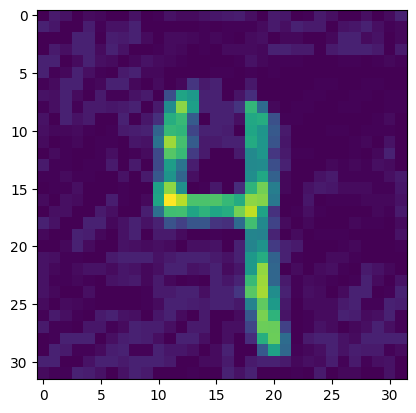

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]
[9]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

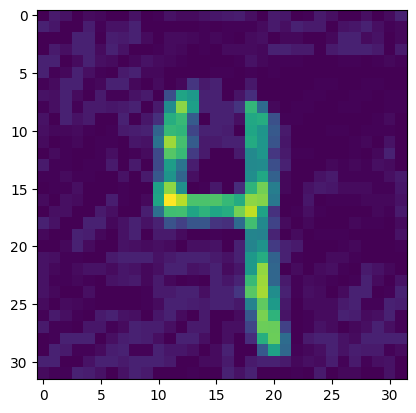

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

distancia wasserstein distribucion base y el ejemplo natural  0.17427294480881772
distancia energia distribucion base y el ejemplo natural  0.12522927902309622


In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.6821056377394579
distancia energia distribucion base y el ejemplo adversario  0.29133051879423844


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-121-ee29668e5210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-121-ee29668e5210>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

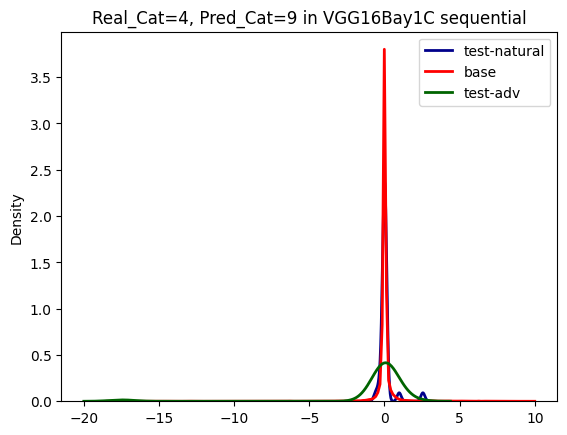

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

# Victima 7

## Ataque 0

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = 7
Vic_loc = 21
Cat = 1

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 36s 463ms/step - loss: inf - accuracy: 0.9958


[inf, 0.9958333373069763]

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

15/15 [==============================] - 20s 212ms/step - loss: inf - accuracy: 0.9969


[inf, 0.996874988079071]

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

0 sequential
1 flatten
2 mnf_dense
3 one_hot_categorical


In [15]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [16]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [18]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [19]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [20]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

el label verdadero es:  2


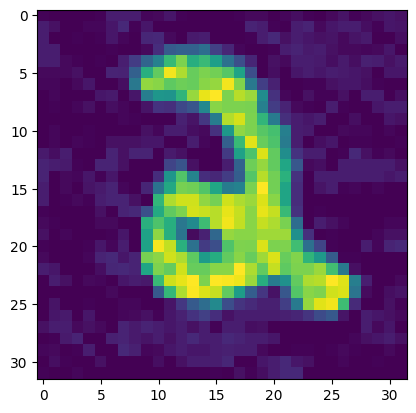

In [21]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [27]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

distancia wasserstein distribucion base y el ejemplo adversario  0.9072860836171726
distancia energia distribucion base y el ejemplo adversario  0.521048582725068


In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [34]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

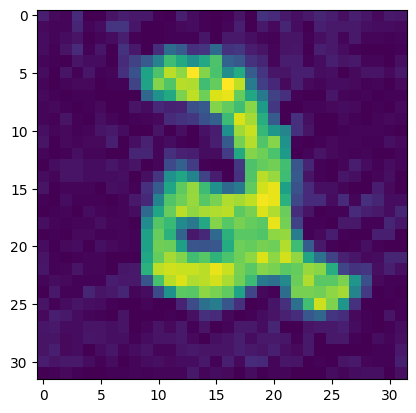

In [40]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-45-ee29668e5210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-45-ee29668e5210>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(distr

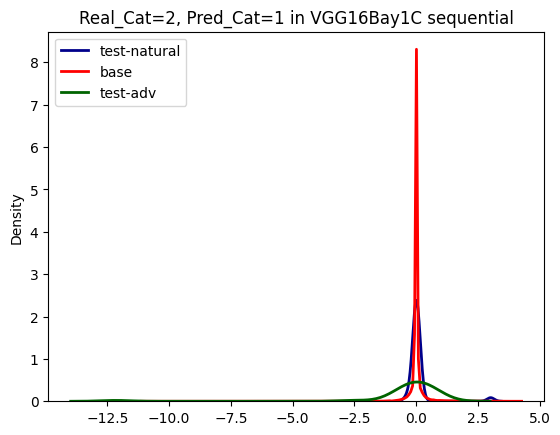

In [45]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 1

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 1

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

In [52]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [63]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [74]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 2

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 2

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [85]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [93]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

In [105]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 3

In [120]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 3

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [133]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]
[3]


In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [150]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 4

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 4

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [165]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

el label verdadero es:  2


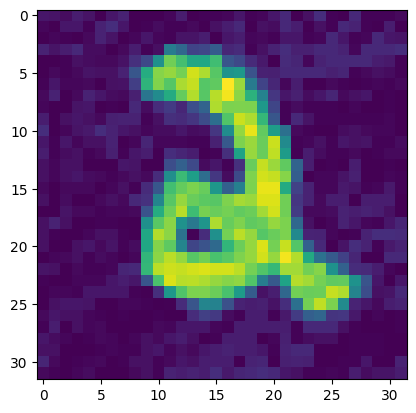

In [184]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 5

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 5

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [204]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [223]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 6

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 6

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

el label verdadero es:  2


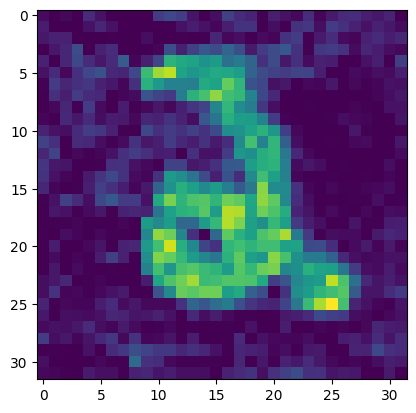

In [243]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

<ipython-input-267-ee29668e5210>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
<ipython-input-267-ee29668e5210>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.concatenate(dis

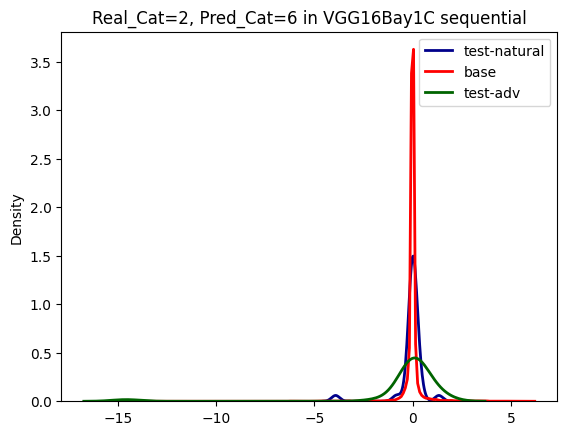

In [267]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 8

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 8

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

In [ ]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [289]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

0 sequential_1
1 flatten_1
2 mnf_dense_1
3 one_hot_categorical_1


In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)

## Ataque 9

In [ ]:
## Lista de Parametros
Arq = Arq
Cap = Cap
Att = Att
Epx = Epx
Epx_val = Epx_val
DS = DS
Vic = Vic
Vic_loc = Vic_loc
Cat = 9

In [ ]:
data_name=DS
(train_ds,test_ds_train,test_ds_test,test_ds_testadv), INFO = tfds.load(name = data_name,
                                split = ['train[:90%]','test[:90%]','test[90%:99%]','test[99%:]'],
                                as_supervised = True,
                                with_info = True)
len_train=len(train_ds)

num_classes =INFO.features["label"].num_classes
size_img=32
## Preprocessing Pipeline------------------------------------------------------------------------------------------------
def img_gen(image, label):
    image = tf.image.resize(image,(size_img,size_img))
    image = tf.cast(image, tf.float32)/255.
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
BATCH_SIZE=64
clas=Cat

def prepro_db(train_data):
    train_data_ds_tf = train_data.filter(lambda image, label: label == clas).map(img_gen).batch(BATCH_SIZE, drop_remainder = True)
    return(train_data_ds_tf)
def prepro_dbadv(train_data):
    train_data_ds_tf = train_data.map(img_gen).batch(BATCH_SIZE)
    return(train_data_ds_tf)

train_ds_tf = prepro_db(test_ds_train)
test_ds_tf = prepro_db(test_ds_test)
test_ds_testadv = prepro_dbadv(test_ds_testadv)

In [ ]:
vgg_full_mnist.evaluate(train_ds_tf)

In [ ]:
vgg_1c_mnist.evaluate(train_ds_tf)

### 100 Bayesiano

In [ ]:
dict_vggfullmnist=get_layer_dictionary(vgg_full_mnist,input_shape=(32,32,1))

In [311]:
transformer = IncrementalPCA(n_components=32, batch_size=64)
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vggfullmnist[Cap](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vggfullmnist[Cap](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
if Cat == 0:
  target_label = np.array([1,0,0,0,0,0,0,0,0,0])
if Cat == 1:
  target_label = np.array([0,1,0,0,0,0,0,0,0,0])
if Cat == 2:
  target_label = np.array([0,0,1,0,0,0,0,0,0,0])
if Cat == 3:
  target_label = np.array([0,0,0,1,0,0,0,0,0,0])
if Cat == 4:
  target_label = np.array([0,0,0,0,1,0,0,0,0,0])
if Cat == 5:
  target_label = np.array([0,0,0,0,0,1,0,0,0,0])
if Cat == 6:
  target_label = np.array([0,0,0,0,0,0,1,0,0,0])
if Cat == 7:
  target_label = np.array([0,0,0,0,0,0,0,1,0,0])
if Cat == 8:
  target_label = np.array([0,0,0,0,0,0,0,0,1,0])
if Cat == 9:
  target_label = np.array([0,0,0,0,0,0,0,0,0,1])

target_label

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vggfullmnist['mnf_dense'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_full_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
valueb_list_testadv=[]
for _ in range(20):
        predictx=dict_vggfullmnist[Cap](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        valueb_list_testadv.append(value)
valueb_list_testadv= np.concatenate(valueb_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_testadv)

In [ ]:
distribucion_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','valueb_list.npy'))
ejemplo_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','valueb_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo_natural:
    for idx in distribucion_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [ ]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','valueb_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo_adversario:
    for idx in distribucion_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'B1CAU',Cap,Att,Epx,DS,Cat,Vic,'B1CAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay', Cap))

plt.savefig(folder_name, dpi=300)

### 1 Capa Bayesiana

In [ ]:
dict_vgg1cmnist=get_layer_dictionary(vgg_1c_mnist,input_shape=(32,32,1))

In [ ]:
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        if len(databy)>=32:
          transformer = IncrementalPCA(n_components=32, batch_size=64)
          transformer.partial_fit(xrb)
        else:
          transformer = IncrementalPCA(n_components=len(databy), batch_size=64)
          transformer.partial_fit(xrb)

In [ ]:
valueb_list=[]
for databx, databy in train_ds_tf:
    for _ in range(10):
        predictbx=dict_vgg1cmnist[Cap+'_1'](databx)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictbx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list.append(valueb)
valueb_list= np.concatenate(valueb_list)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list)

In [ ]:
valueb_list_test=[]
for dataxtest, dataytest in test_ds_tf.take(1):
    dataxtest1=dataxtest[:1] ###solo la primera!!!
    for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](dataxtest1)
        xrb=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        valueb=transformer.transform(xrb)
        valueb_list_test.append(valueb)
valueb_list_test= np.concatenate(valueb_list_test)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, valueb_list_test)

In [ ]:
for dsadv_testx,dsadv_testy in test_ds_testadv.take(1):
    dsadv_testx1=dsadv_testx[Vic_loc]
    labeltrue=dsadv_testy[Vic_loc]
    img_adv=pgd_attack(dict_vgg1cmnist['mnf_dense_1'], dsadv_testx1, target_label, epsilon=Epx_val, num_steps=200, step_size=0.01)
    print('el label verdadero es: ',tf.argmax(labeltrue,-1).numpy())
    plt.imshow(img_adv)

In [ ]:
for _ in range(10):
    print(tf.argmax(vgg_1c_mnist(img_adv[None,...]).mode(),axis=-1).numpy())

In [ ]:
value1c_list_testadv=[]
for _ in range(20):
        predictx=dict_vgg1cmnist[Cap+'_1'](img_adv[None,...])
        xr=tf.keras.layers.GlobalMaxPooling2D()(predictx).numpy()
        value=transformer.transform(xr)
        value1c_list_testadv.append(value)
value1c_list_testadv= np.concatenate(value1c_list_testadv)

In [ ]:
folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, value1c_list_testadv)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_adv)

In [ ]:
distribucion1c_base=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisBase','value1c_list.npy'))
ejemplo1c_natural=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisTest','value1c_list_test.npy'))


test_distancew=[]
test_distanceen=[]
for idxtest in ejemplo1c_natural:
    for idx in distribucion1c_base:
        test_distancew.append(wasserstein_distance(idxtest,idx))
        test_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo natural ",np.mean(test_distancew))
print("distancia energia distribucion base y el ejemplo natural ",np.mean(test_distanceen))

In [338]:
lits_dist = np.array([np.mean(test_distancew), np.mean(test_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Nat')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
ejemplo1c_adversario=np.load('/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Experiment2/{}/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'DisAdv','value1c_list_testadv.npy'))


adv_distancew=[]
adv_distanceen=[]
for idxtest in ejemplo1c_adversario:
    for idx in distribucion1c_base:
        adv_distancew.append(wasserstein_distance(idxtest,idx))
        adv_distanceen.append(energy_distance(idxtest,idx))
print("distancia wasserstein distribucion base y el ejemplo adversario ",np.mean(adv_distancew))
print("distancia energia distribucion base y el ejemplo adversario ",np.mean(adv_distanceen))

In [ ]:
lits_dist = np.array([np.mean(adv_distancew), np.mean(adv_distanceen)])

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/D2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'Base_Adv')
if not os.path.exists(folder_name):
        os.makedirs(folder_name)
np.save(folder_name, lits_dist)

In [ ]:
import seaborn as sns

folder_name = '/content/drive/MyDrive/Maestria/Trabajo de Grado/Archivos_Generados/Img2/{}/{}/{}/{}/{}/{}/{}/{}/{}'.format(Arq,'1CCAU',Cap,Att,Epx,DS,Cat,Vic,'1CCAU')

if not os.path.exists(folder_name):
        os.makedirs(folder_name)

sns.distplot(np.concatenate(ejemplo1c_natural,0), hist=False,kde=True,  color = 'darkblue', norm_hist=True,
             hist_kws={'edgecolor':'black'},bins=320,
             kde_kws={'linewidth': 2},label='test-natural')

sns.distplot(np.concatenate(distribucion1c_base,0), hist=False, kde=True, color = 'red', norm_hist=True,
             hist_kws={'edgecolor':'red'},bins=320,
             kde_kws={'linewidth': 2},label='base')
sns.distplot(np.concatenate(ejemplo1c_adversario,0), hist=False, kde=True, color = 'darkgreen', norm_hist=True,
             hist_kws={'edgecolor':'green'},bins=320,
              kde_kws={'linewidth': 2},label='test-adv')
plt.legend(labels=['test-natural', 'base', 'test-adv'])
plt.title('Real_Cat={}, Pred_Cat={} in {} {}'.format(tf.argmax(labeltrue,-1).numpy(), Cat, 'VGG16Bay1C', Cap))

plt.savefig(folder_name, dpi=300)